In [1]:
!pip install sentence-transformers
!pip install pandas

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:


from sklearn.metrics import accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from sentence_transformers import SentenceTransformer, InputExample, losses, models, datasets, evaluation
from torch.utils.data import DataLoader

from sklearn.manifold import TSNE
from matplotlib import pyplot as plt

# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np

import torch
import random
import torch

def set_seed(seed):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)

In [3]:
#Load the sprag dataset
data = pd.read_csv("refstdcombined.csv")
data.head(2)

,Unnamed: 0,QuestionID,ReferenceAnswer,StudentAnswer,Score1,Score2,avg_score,max_score
0,0.0,PythonQ001,"List, Set and Dictionary are mutable data stru...",Tha object structures which can be changeable ...,1.0,0.0,0.5,1.0
1,1.0,PythonQ001,"List, Set and Dictionary are mutable data stru...",Tuple,0.0,0.0,0.0,0.0


In [4]:
data['bin_score'] = data.apply(lambda row : 1 if row.avg_score>=3 else 0, axis=1)

In [5]:
data.head(2)

,Unnamed: 0,QuestionID,ReferenceAnswer,StudentAnswer,Score1,Score2,avg_score,max_score,bin_score
0,0.0,PythonQ001,"List, Set and Dictionary are mutable data stru...",Tha object structures which can be changeable ...,1.0,0.0,0.5,1.0,0
1,1.0,PythonQ001,"List, Set and Dictionary are mutable data stru...",Tuple,0.0,0.0,0.0,0.0,0


In [6]:
data = data.dropna()

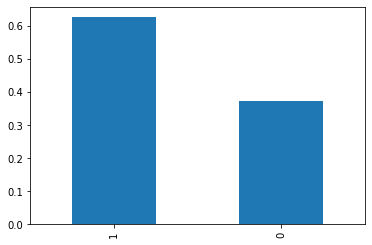

In [7]:
data['bin_score'].value_counts(normalize=True).plot(kind='bar');

In [8]:
#### Just some code to print debug information to stdout
import logging
from sentence_transformers import LoggingHandler
logging.basicConfig(format='%(asctime)s - %(message)s',
                    datefmt='%Y-%m-%d %H:%M:%S',
                    level=logging.INFO,
                    handlers=[LoggingHandler()])

In [9]:
from sklearn.model_selection import train_test_split

# Storing labels in array
labels = data['bin_score'].values

# Dropping labels column from data
data = data.drop(['bin_score'], axis=1)

# Splitting data into train and test sets in a 70/30 ratio
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, stratify=labels, random_state=42, test_size=0.2)

In [10]:
len(train_data)*0.5, type(train_labels), train_labels.shape


(1604.0, numpy.ndarray, (3208,))

In [11]:
train_data = train_data.iloc[0:1604]
train_labels = train_labels[0:1604]

In [12]:
type(train_data), type(train_labels), len(train_data), len(train_labels)

(pandas.core.frame.DataFrame, numpy.ndarray, 1604, 1604)

In [13]:
def sentence_pairs_generation(sentence1, sentence2, labels, pairs):
	# initialize two empty lists to hold the (sentence, sentence) pairs and
	# labels to indicate if the grade of the pair

  numClassesList = np.unique(labels)
  #print(numClassesList)
  idx = [np.where(labels == i)[0] for i in numClassesList]
  #print(idx)

  for idxA in range(len(sentence1)):      
    dAns = sentence1[idxA]
    sAns = sentence2[idxA]
    label = int(labels[idxA])
    
		  # prepare a pair and update the sentences and labels lists, respectively
    pairs.append(InputExample(texts=[dAns, sAns], label=label))

     
	# return a 2-tuple of our image pairs and labels
  return (pairs)

In [14]:
set_seed(0)
# Equal samples per class training
#train_df_sample = pd.concat([train_df[train_df[1]==0].sample(num_training), train_df[train_df[1]==1].sample(num_training)])
x_train_dA = train_data['ReferenceAnswer'].values.tolist()
x_train_sA = train_data['StudentAnswer'].values.tolist()
y_train = train_labels.tolist()
y_train = [int(x) for x in y_train]

In [15]:
#use test dataset as dev dataset
x_test_dA = test_data['ReferenceAnswer'].values.tolist()
x_test_sA = test_data['StudentAnswer'].values.tolist()
y_test = test_labels / 1.0
y_test = test_labels.tolist()
#y_test = [int(x) for x in y_test]

test_examples = [] 
test_examples = sentence_pairs_generation(np.array(x_test_dA), np.array(x_test_sA), np.array(y_test), test_examples)

In [16]:
train_examples = [] 
train_examples = sentence_pairs_generation(np.array(x_train_dA), np.array(x_train_sA), np.array(y_train), train_examples)

In [17]:
# Save path of the model
from datetime import datetime
model_save_path = 'output/training_sprag_v4_'+datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

In [18]:
from sentence_transformers import evaluation
import math


def train_and_evaluate(st_model, train_dataloader, test_dataloader, num_epochs,model_save_path):
  model = SentenceTransformer(st_model)
  #for evaluation
  train_loss = losses.SoftmaxLoss(model=model, sentence_embedding_dimension=model.get_sentence_embedding_dimension(), num_labels=2)
  #test_evaluator = evaluation.EmbeddingSimilarityEvaluator.from_input_examples(test_examples, batch_size=16, name='SPRAG-test')
  x_test_dA = test_data['ReferenceAnswer'].values.tolist()
  x_test_sA = test_data['StudentAnswer'].values.tolist()
  y_test = test_labels 

  evaluator = evaluation.BinaryClassificationEvaluator(x_test_dA, x_test_sA, y_test)

  #configuring the training
  warmup_steps = math.ceil(len(train_dataloader) * num_epochs * 0.1) #10% of train data for warm-up
  print(warmup_steps)
  #train_loss = losses.CosineSimilarityLoss(model)
  model.fit(train_objectives=[(train_dataloader, train_loss)],
          evaluator=evaluator,
          epochs=num_epochs,
          warmup_steps=warmup_steps,
          show_progress_bar=True,  
          #evaluation_steps=50, 
          output_path=model_save_path,)
  print("Training done...")

In [19]:
st_model = 'stsb-distilbert-base'
num_epochs = 10
batch_size=16
model_save_path = "binary_sim_output/"+st_model
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=batch_size)
  
test_dataloader = DataLoader(test_examples, shuffle=True, batch_size=batch_size)
model = train_and_evaluate(st_model, train_dataloader, test_dataloader, num_epochs, model_save_path)
print("\n\n")
print(" "*20, "*"*10, st_model , "*"*10)

# Load the stored model and evaluate its performance on mohler test dataset
model = SentenceTransformer(model_save_path)
train_loss = losses.SoftmaxLoss(model=model, sentence_embedding_dimension=model.get_sentence_embedding_dimension(), num_labels=2)
test_evaluator = evaluation.EmbeddingSimilarityEvaluator.from_input_examples(test_examples, batch_size=16, name='SPRAG-test')
test_evaluator(model, output_path=model_save_path)
train_loss.cuda()

x_test_dA = test_data['ReferenceAnswer'].values.tolist()
x_test_sA = test_data['StudentAnswer'].values.tolist()
y_test = test_labels 

evaluator = evaluation.BinaryClassificationEvaluator(x_test_dA, x_test_sA, y_test)
evaluator(model, output_path=model_save_path)


2022-09-06 21:54:37 - Load pretrained SentenceTransformer: stsb-distilbert-base
2022-09-06 21:54:38 - Use pytorch device: cuda
2022-09-06 21:54:38 - Softmax loss: #Vectors concatenated: 3
101


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/101 [00:00<?, ?it/s]

2022-09-06 21:54:58 - Binary Accuracy Evaluation of the model on  dataset after epoch 0:
2022-09-06 21:54:59 - Accuracy with Cosine-Similarity:           75.56	(Threshold: 0.4625)
2022-09-06 21:54:59 - F1 with Cosine-Similarity:                 82.51	(Threshold: 0.3279)
2022-09-06 21:54:59 - Precision with Cosine-Similarity:          72.00
2022-09-06 21:54:59 - Recall with Cosine-Similarity:             96.62
2022-09-06 21:54:59 - Average Precision with Cosine-Similarity:  88.16

2022-09-06 21:54:59 - Accuracy with Manhattan-Distance:           75.44	(Threshold: 342.1565)
2022-09-06 21:54:59 - F1 with Manhattan-Distance:                 82.65	(Threshold: 392.2606)
2022-09-06 21:54:59 - Precision with Manhattan-Distance:          72.77
2022-09-06 21:54:59 - Recall with Manhattan-Distance:             95.63
2022-09-06 21:54:59 - Average Precision with Manhattan-Distance:  88.49

2022-09-06 21:54:59 - Accuracy with Euclidean-Distance:           75.69	(Threshold: 15.1575)
2022-09-06 21:54:

Iteration:   0%|          | 0/101 [00:00<?, ?it/s]

2022-09-06 21:55:14 - Binary Accuracy Evaluation of the model on  dataset after epoch 1:
2022-09-06 21:55:15 - Accuracy with Cosine-Similarity:           78.93	(Threshold: 0.4148)
2022-09-06 21:55:15 - F1 with Cosine-Similarity:                 84.65	(Threshold: 0.3133)
2022-09-06 21:55:15 - Precision with Cosine-Similarity:          76.44
2022-09-06 21:55:15 - Recall with Cosine-Similarity:             94.83
2022-09-06 21:55:15 - Average Precision with Cosine-Similarity:  90.74

2022-09-06 21:55:15 - Accuracy with Manhattan-Distance:           78.93	(Threshold: 375.5246)
2022-09-06 21:55:15 - F1 with Manhattan-Distance:                 84.66	(Threshold: 410.6037)
2022-09-06 21:55:15 - Precision with Manhattan-Distance:          75.71
2022-09-06 21:55:15 - Recall with Manhattan-Distance:             96.02
2022-09-06 21:55:15 - Average Precision with Manhattan-Distance:  90.90

2022-09-06 21:55:15 - Accuracy with Euclidean-Distance:           79.18	(Threshold: 17.1443)
2022-09-06 21:55:

Iteration:   0%|          | 0/101 [00:00<?, ?it/s]

2022-09-06 21:55:33 - Binary Accuracy Evaluation of the model on  dataset after epoch 2:
2022-09-06 21:55:34 - Accuracy with Cosine-Similarity:           80.05	(Threshold: 0.2635)
2022-09-06 21:55:34 - F1 with Cosine-Similarity:                 85.59	(Threshold: 0.1922)
2022-09-06 21:55:34 - Precision with Cosine-Similarity:          76.69
2022-09-06 21:55:34 - Recall with Cosine-Similarity:             96.82
2022-09-06 21:55:34 - Average Precision with Cosine-Similarity:  91.62

2022-09-06 21:55:34 - Accuracy with Manhattan-Distance:           80.92	(Threshold: 403.3790)
2022-09-06 21:55:34 - F1 with Manhattan-Distance:                 85.82	(Threshold: 403.3790)
2022-09-06 21:55:34 - Precision with Manhattan-Distance:          80.38
2022-09-06 21:55:34 - Recall with Manhattan-Distance:             92.05
2022-09-06 21:55:34 - Average Precision with Manhattan-Distance:  91.75

2022-09-06 21:55:34 - Accuracy with Euclidean-Distance:           80.67	(Threshold: 18.0333)
2022-09-06 21:55:

Iteration:   0%|          | 0/101 [00:00<?, ?it/s]

2022-09-06 21:55:50 - Binary Accuracy Evaluation of the model on  dataset after epoch 3:
2022-09-06 21:55:51 - Accuracy with Cosine-Similarity:           80.67	(Threshold: 0.2164)
2022-09-06 21:55:51 - F1 with Cosine-Similarity:                 85.92	(Threshold: 0.2099)
2022-09-06 21:55:51 - Precision with Cosine-Similarity:          79.10
2022-09-06 21:55:51 - Recall with Cosine-Similarity:             94.04
2022-09-06 21:55:51 - Average Precision with Cosine-Similarity:  91.47

2022-09-06 21:55:51 - Accuracy with Manhattan-Distance:           80.55	(Threshold: 444.3318)
2022-09-06 21:55:51 - F1 with Manhattan-Distance:                 85.97	(Threshold: 444.3318)
2022-09-06 21:55:51 - Precision with Manhattan-Distance:          78.49
2022-09-06 21:55:51 - Recall with Manhattan-Distance:             95.03
2022-09-06 21:55:51 - Average Precision with Manhattan-Distance:  91.63

2022-09-06 21:55:51 - Accuracy with Euclidean-Distance:           80.42	(Threshold: 19.9933)
2022-09-06 21:55:

Iteration:   0%|          | 0/101 [00:00<?, ?it/s]

2022-09-06 21:56:08 - Binary Accuracy Evaluation of the model on  dataset after epoch 4:
2022-09-06 21:56:09 - Accuracy with Cosine-Similarity:           81.05	(Threshold: 0.3362)
2022-09-06 21:56:09 - F1 with Cosine-Similarity:                 86.04	(Threshold: 0.1265)
2022-09-06 21:56:09 - Precision with Cosine-Similarity:          77.81
2022-09-06 21:56:09 - Recall with Cosine-Similarity:             96.22
2022-09-06 21:56:09 - Average Precision with Cosine-Similarity:  91.76

2022-09-06 21:56:09 - Accuracy with Manhattan-Distance:           81.30	(Threshold: 412.2153)
2022-09-06 21:56:09 - F1 with Manhattan-Distance:                 86.43	(Threshold: 465.0084)
2022-09-06 21:56:09 - Precision with Manhattan-Distance:          78.44
2022-09-06 21:56:09 - Recall with Manhattan-Distance:             96.22
2022-09-06 21:56:09 - Average Precision with Manhattan-Distance:  91.89

2022-09-06 21:56:09 - Accuracy with Euclidean-Distance:           81.55	(Threshold: 18.9065)
2022-09-06 21:56:

Iteration:   0%|          | 0/101 [00:00<?, ?it/s]

2022-09-06 21:56:26 - Binary Accuracy Evaluation of the model on  dataset after epoch 5:
2022-09-06 21:56:27 - Accuracy with Cosine-Similarity:           81.55	(Threshold: 0.1651)
2022-09-06 21:56:27 - F1 with Cosine-Similarity:                 86.42	(Threshold: 0.1651)
2022-09-06 21:56:27 - Precision with Cosine-Similarity:          80.24
2022-09-06 21:56:27 - Recall with Cosine-Similarity:             93.64
2022-09-06 21:56:27 - Average Precision with Cosine-Similarity:  91.05

2022-09-06 21:56:27 - Accuracy with Manhattan-Distance:           81.55	(Threshold: 457.4250)
2022-09-06 21:56:27 - F1 with Manhattan-Distance:                 86.42	(Threshold: 457.4250)
2022-09-06 21:56:27 - Precision with Manhattan-Distance:          80.24
2022-09-06 21:56:27 - Recall with Manhattan-Distance:             93.64
2022-09-06 21:56:27 - Average Precision with Manhattan-Distance:  91.22

2022-09-06 21:56:27 - Accuracy with Euclidean-Distance:           81.55	(Threshold: 21.0525)
2022-09-06 21:56:

Iteration:   0%|          | 0/101 [00:00<?, ?it/s]

2022-09-06 21:56:43 - Binary Accuracy Evaluation of the model on  dataset after epoch 6:
2022-09-06 21:56:44 - Accuracy with Cosine-Similarity:           81.17	(Threshold: 0.1861)
2022-09-06 21:56:44 - F1 with Cosine-Similarity:                 86.11	(Threshold: 0.1861)
2022-09-06 21:56:44 - Precision with Cosine-Similarity:          80.14
2022-09-06 21:56:44 - Recall with Cosine-Similarity:             93.04
2022-09-06 21:56:44 - Average Precision with Cosine-Similarity:  90.90

2022-09-06 21:56:44 - Accuracy with Manhattan-Distance:           81.17	(Threshold: 437.7562)
2022-09-06 21:56:44 - F1 with Manhattan-Distance:                 86.11	(Threshold: 457.6835)
2022-09-06 21:56:44 - Precision with Manhattan-Distance:          80.14
2022-09-06 21:56:44 - Recall with Manhattan-Distance:             93.04
2022-09-06 21:56:44 - Average Precision with Manhattan-Distance:  90.98

2022-09-06 21:56:44 - Accuracy with Euclidean-Distance:           81.55	(Threshold: 20.5196)
2022-09-06 21:56:

Iteration:   0%|          | 0/101 [00:00<?, ?it/s]

2022-09-06 21:57:00 - Binary Accuracy Evaluation of the model on  dataset after epoch 7:
2022-09-06 21:57:01 - Accuracy with Cosine-Similarity:           80.92	(Threshold: 0.2051)
2022-09-06 21:57:01 - F1 with Cosine-Similarity:                 85.79	(Threshold: 0.0401)
2022-09-06 21:57:01 - Precision with Cosine-Similarity:          78.33
2022-09-06 21:57:01 - Recall with Cosine-Similarity:             94.83
2022-09-06 21:57:01 - Average Precision with Cosine-Similarity:  90.71

2022-09-06 21:57:01 - Accuracy with Manhattan-Distance:           81.17	(Threshold: 455.0645)
2022-09-06 21:57:01 - F1 with Manhattan-Distance:                 86.02	(Threshold: 493.6718)
2022-09-06 21:57:01 - Precision with Manhattan-Distance:          78.71
2022-09-06 21:57:01 - Recall with Manhattan-Distance:             94.83
2022-09-06 21:57:01 - Average Precision with Manhattan-Distance:  90.79

2022-09-06 21:57:01 - Accuracy with Euclidean-Distance:           81.05	(Threshold: 20.8879)
2022-09-06 21:57:

Iteration:   0%|          | 0/101 [00:00<?, ?it/s]

2022-09-06 21:57:18 - Binary Accuracy Evaluation of the model on  dataset after epoch 8:
2022-09-06 21:57:19 - Accuracy with Cosine-Similarity:           80.92	(Threshold: 0.2144)
2022-09-06 21:57:19 - F1 with Cosine-Similarity:                 85.77	(Threshold: 0.0287)
2022-09-06 21:57:19 - Precision with Cosine-Similarity:          78.42
2022-09-06 21:57:19 - Recall with Cosine-Similarity:             94.63
2022-09-06 21:57:19 - Average Precision with Cosine-Similarity:  90.70

2022-09-06 21:57:19 - Accuracy with Manhattan-Distance:           81.42	(Threshold: 454.4614)
2022-09-06 21:57:19 - F1 with Manhattan-Distance:                 86.06	(Threshold: 456.1006)
2022-09-06 21:57:19 - Precision with Manhattan-Distance:          81.27
2022-09-06 21:57:19 - Recall with Manhattan-Distance:             91.45
2022-09-06 21:57:19 - Average Precision with Manhattan-Distance:  90.81

2022-09-06 21:57:19 - Accuracy with Euclidean-Distance:           81.30	(Threshold: 20.5470)
2022-09-06 21:57:

Iteration:   0%|          | 0/101 [00:00<?, ?it/s]

2022-09-06 21:57:35 - Binary Accuracy Evaluation of the model on  dataset after epoch 9:
2022-09-06 21:57:36 - Accuracy with Cosine-Similarity:           80.92	(Threshold: 0.2122)
2022-09-06 21:57:36 - F1 with Cosine-Similarity:                 85.74	(Threshold: 0.1296)
2022-09-06 21:57:36 - Precision with Cosine-Similarity:          79.79
2022-09-06 21:57:36 - Recall with Cosine-Similarity:             92.64
2022-09-06 21:57:36 - Average Precision with Cosine-Similarity:  90.58

2022-09-06 21:57:36 - Accuracy with Manhattan-Distance:           81.30	(Threshold: 455.7488)
2022-09-06 21:57:36 - F1 with Manhattan-Distance:                 86.03	(Threshold: 462.2429)
2022-09-06 21:57:36 - Precision with Manhattan-Distance:          80.91
2022-09-06 21:57:36 - Recall with Manhattan-Distance:             91.85
2022-09-06 21:57:36 - Average Precision with Manhattan-Distance:  90.70

2022-09-06 21:57:36 - Accuracy with Euclidean-Distance:           81.17	(Threshold: 20.5663)
2022-09-06 21:57:

0.9193768466669205

In [20]:
st_model = 'sentence-transformers/paraphrase-albert-small-v2'
num_epochs = 10
batch_size=16
model_save_path = "binary_sim_output/"+st_model
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=batch_size)
  
test_dataloader = DataLoader(test_examples, shuffle=True, batch_size=batch_size)
model = train_and_evaluate(st_model, train_dataloader, test_dataloader, num_epochs, model_save_path)
print("\n\n")
print(" "*20, "*"*10, st_model , "*"*10)

# Load the stored model and evaluate its performance on mohler test dataset
model = SentenceTransformer(model_save_path)
train_loss = losses.SoftmaxLoss(model=model, sentence_embedding_dimension=model.get_sentence_embedding_dimension(), num_labels=2)
test_evaluator = evaluation.EmbeddingSimilarityEvaluator.from_input_examples(test_examples, batch_size=16, name='SPRAG-test')
test_evaluator(model, output_path=model_save_path)
train_loss.cuda()

x_test_dA = test_data['ReferenceAnswer'].values.tolist()
x_test_sA = test_data['StudentAnswer'].values.tolist()
y_test = test_labels 

evaluator = evaluation.BinaryClassificationEvaluator(x_test_dA, x_test_sA, y_test)
evaluator(model, output_path=model_save_path)


2022-09-06 21:57:40 - Load pretrained SentenceTransformer: sentence-transformers/paraphrase-albert-small-v2
2022-09-06 21:57:40 - Use pytorch device: cuda
2022-09-06 21:57:40 - Softmax loss: #Vectors concatenated: 3
101


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/101 [00:00<?, ?it/s]

2022-09-06 21:57:57 - Binary Accuracy Evaluation of the model on  dataset after epoch 0:
2022-09-06 21:57:58 - Accuracy with Cosine-Similarity:           74.56	(Threshold: 0.5491)
2022-09-06 21:57:58 - F1 with Cosine-Similarity:                 81.11	(Threshold: 0.3682)
2022-09-06 21:57:58 - Precision with Cosine-Similarity:          71.89
2022-09-06 21:57:58 - Recall with Cosine-Similarity:             93.04
2022-09-06 21:57:58 - Average Precision with Cosine-Similarity:  87.10

2022-09-06 21:57:58 - Accuracy with Manhattan-Distance:           73.57	(Threshold: 450.3566)
2022-09-06 21:57:58 - F1 with Manhattan-Distance:                 80.33	(Threshold: 516.3202)
2022-09-06 21:57:58 - Precision with Manhattan-Distance:          68.34
2022-09-06 21:57:58 - Recall with Manhattan-Distance:             97.42
2022-09-06 21:57:58 - Average Precision with Manhattan-Distance:  85.97

2022-09-06 21:57:58 - Accuracy with Euclidean-Distance:           73.57	(Threshold: 20.4476)
2022-09-06 21:57:

Iteration:   0%|          | 0/101 [00:00<?, ?it/s]

2022-09-06 21:58:14 - Binary Accuracy Evaluation of the model on  dataset after epoch 1:
2022-09-06 21:58:16 - Accuracy with Cosine-Similarity:           77.68	(Threshold: 0.4408)
2022-09-06 21:58:16 - F1 with Cosine-Similarity:                 83.53	(Threshold: 0.4388)
2022-09-06 21:58:16 - Precision with Cosine-Similarity:          77.74
2022-09-06 21:58:16 - Recall with Cosine-Similarity:             90.26
2022-09-06 21:58:16 - Average Precision with Cosine-Similarity:  88.80

2022-09-06 21:58:16 - Accuracy with Manhattan-Distance:           77.18	(Threshold: 570.0612)
2022-09-06 21:58:16 - F1 with Manhattan-Distance:                 83.23	(Threshold: 576.8286)
2022-09-06 21:58:16 - Precision with Manhattan-Distance:          76.50
2022-09-06 21:58:16 - Recall with Manhattan-Distance:             91.25
2022-09-06 21:58:16 - Average Precision with Manhattan-Distance:  88.25

2022-09-06 21:58:16 - Accuracy with Euclidean-Distance:           77.43	(Threshold: 25.3370)
2022-09-06 21:58:

Iteration:   0%|          | 0/101 [00:00<?, ?it/s]

2022-09-06 21:58:32 - Binary Accuracy Evaluation of the model on  dataset after epoch 2:
2022-09-06 21:58:34 - Accuracy with Cosine-Similarity:           78.18	(Threshold: 0.4096)
2022-09-06 21:58:34 - F1 with Cosine-Similarity:                 83.78	(Threshold: 0.3905)
2022-09-06 21:58:34 - Precision with Cosine-Similarity:          77.72
2022-09-06 21:58:34 - Recall with Cosine-Similarity:             90.85
2022-09-06 21:58:34 - Average Precision with Cosine-Similarity:  88.90

2022-09-06 21:58:34 - Accuracy with Manhattan-Distance:           77.93	(Threshold: 636.0503)
2022-09-06 21:58:34 - F1 with Manhattan-Distance:                 83.81	(Threshold: 644.1801)
2022-09-06 21:58:34 - Precision with Manhattan-Distance:          77.63
2022-09-06 21:58:34 - Recall with Manhattan-Distance:             91.05
2022-09-06 21:58:34 - Average Precision with Manhattan-Distance:  88.63

2022-09-06 21:58:34 - Accuracy with Euclidean-Distance:           77.56	(Threshold: 28.9566)
2022-09-06 21:58:

Iteration:   0%|          | 0/101 [00:00<?, ?it/s]

2022-09-06 21:58:50 - Binary Accuracy Evaluation of the model on  dataset after epoch 3:
2022-09-06 21:58:51 - Accuracy with Cosine-Similarity:           79.43	(Threshold: 0.3941)
2022-09-06 21:58:51 - F1 with Cosine-Similarity:                 84.60	(Threshold: 0.3419)
2022-09-06 21:58:51 - Precision with Cosine-Similarity:          77.70
2022-09-06 21:58:51 - Recall with Cosine-Similarity:             92.84
2022-09-06 21:58:51 - Average Precision with Cosine-Similarity:  89.78

2022-09-06 21:58:51 - Accuracy with Manhattan-Distance:           79.55	(Threshold: 676.6406)
2022-09-06 21:58:51 - F1 with Manhattan-Distance:                 84.84	(Threshold: 676.6406)
2022-09-06 21:58:51 - Precision with Manhattan-Distance:          79.27
2022-09-06 21:58:51 - Recall with Manhattan-Distance:             91.25
2022-09-06 21:58:51 - Average Precision with Manhattan-Distance:  89.74

2022-09-06 21:58:51 - Accuracy with Euclidean-Distance:           79.18	(Threshold: 30.8372)
2022-09-06 21:58:

Iteration:   0%|          | 0/101 [00:00<?, ?it/s]

2022-09-06 21:59:08 - Binary Accuracy Evaluation of the model on  dataset after epoch 4:
2022-09-06 21:59:09 - Accuracy with Cosine-Similarity:           79.30	(Threshold: 0.3782)
2022-09-06 21:59:09 - F1 with Cosine-Similarity:                 84.49	(Threshold: 0.3477)
2022-09-06 21:59:09 - Precision with Cosine-Similarity:          79.27
2022-09-06 21:59:09 - Recall with Cosine-Similarity:             90.46
2022-09-06 21:59:09 - Average Precision with Cosine-Similarity:  89.71

2022-09-06 21:59:09 - Accuracy with Manhattan-Distance:           79.05	(Threshold: 707.1788)
2022-09-06 21:59:09 - F1 with Manhattan-Distance:                 84.56	(Threshold: 739.5284)
2022-09-06 21:59:09 - Precision with Manhattan-Distance:          77.09
2022-09-06 21:59:09 - Recall with Manhattan-Distance:             93.64
2022-09-06 21:59:09 - Average Precision with Manhattan-Distance:  90.02

2022-09-06 21:59:09 - Accuracy with Euclidean-Distance:           79.05	(Threshold: 32.2870)
2022-09-06 21:59:

Iteration:   0%|          | 0/101 [00:00<?, ?it/s]

2022-09-06 21:59:26 - Binary Accuracy Evaluation of the model on  dataset after epoch 5:
2022-09-06 21:59:27 - Accuracy with Cosine-Similarity:           78.93	(Threshold: 0.2661)
2022-09-06 21:59:27 - F1 with Cosine-Similarity:                 84.65	(Threshold: 0.2415)
2022-09-06 21:59:27 - Precision with Cosine-Similarity:          77.93
2022-09-06 21:59:27 - Recall with Cosine-Similarity:             92.64
2022-09-06 21:59:27 - Average Precision with Cosine-Similarity:  89.92

2022-09-06 21:59:27 - Accuracy with Manhattan-Distance:           78.68	(Threshold: 739.3045)
2022-09-06 21:59:27 - F1 with Manhattan-Distance:                 84.53	(Threshold: 796.8097)
2022-09-06 21:59:27 - Precision with Manhattan-Distance:          77.18
2022-09-06 21:59:27 - Recall with Manhattan-Distance:             93.44
2022-09-06 21:59:27 - Average Precision with Manhattan-Distance:  90.22

2022-09-06 21:59:27 - Accuracy with Euclidean-Distance:           78.68	(Threshold: 33.7109)
2022-09-06 21:59:

Iteration:   0%|          | 0/101 [00:00<?, ?it/s]

2022-09-06 21:59:41 - Binary Accuracy Evaluation of the model on  dataset after epoch 6:
2022-09-06 21:59:42 - Accuracy with Cosine-Similarity:           78.80	(Threshold: 0.3055)
2022-09-06 21:59:42 - F1 with Cosine-Similarity:                 84.48	(Threshold: 0.2482)
2022-09-06 21:59:42 - Precision with Cosine-Similarity:          77.36
2022-09-06 21:59:42 - Recall with Cosine-Similarity:             93.04
2022-09-06 21:59:42 - Average Precision with Cosine-Similarity:  89.48

2022-09-06 21:59:42 - Accuracy with Manhattan-Distance:           79.43	(Threshold: 755.2386)
2022-09-06 21:59:42 - F1 with Manhattan-Distance:                 84.57	(Threshold: 755.2386)
2022-09-06 21:59:42 - Precision with Manhattan-Distance:          79.86
2022-09-06 21:59:42 - Recall with Manhattan-Distance:             89.86
2022-09-06 21:59:42 - Average Precision with Manhattan-Distance:  89.81

2022-09-06 21:59:42 - Accuracy with Euclidean-Distance:           79.05	(Threshold: 34.4817)
2022-09-06 21:59:

Iteration:   0%|          | 0/101 [00:00<?, ?it/s]

2022-09-06 21:59:59 - Binary Accuracy Evaluation of the model on  dataset after epoch 7:
2022-09-06 22:00:00 - Accuracy with Cosine-Similarity:           79.05	(Threshold: 0.2268)
2022-09-06 22:00:00 - F1 with Cosine-Similarity:                 84.73	(Threshold: 0.2268)
2022-09-06 22:00:00 - Precision with Cosine-Similarity:          78.06
2022-09-06 22:00:00 - Recall with Cosine-Similarity:             92.64
2022-09-06 22:00:00 - Average Precision with Cosine-Similarity:  89.65

2022-09-06 22:00:00 - Accuracy with Manhattan-Distance:           78.80	(Threshold: 794.8715)
2022-09-06 22:00:00 - F1 with Manhattan-Distance:                 84.53	(Threshold: 819.5441)
2022-09-06 22:00:00 - Precision with Manhattan-Distance:          77.18
2022-09-06 22:00:00 - Recall with Manhattan-Distance:             93.44
2022-09-06 22:00:00 - Average Precision with Manhattan-Distance:  89.90

2022-09-06 22:00:00 - Accuracy with Euclidean-Distance:           78.68	(Threshold: 36.9973)
2022-09-06 22:00:

Iteration:   0%|          | 0/101 [00:00<?, ?it/s]

2022-09-06 22:00:17 - Binary Accuracy Evaluation of the model on  dataset after epoch 8:
2022-09-06 22:00:18 - Accuracy with Cosine-Similarity:           79.05	(Threshold: 0.2298)
2022-09-06 22:00:18 - F1 with Cosine-Similarity:                 84.68	(Threshold: 0.2180)
2022-09-06 22:00:18 - Precision with Cosine-Similarity:          77.83
2022-09-06 22:00:18 - Recall with Cosine-Similarity:             92.84
2022-09-06 22:00:18 - Average Precision with Cosine-Similarity:  89.79

2022-09-06 22:00:18 - Accuracy with Manhattan-Distance:           79.05	(Threshold: 785.2786)
2022-09-06 22:00:18 - F1 with Manhattan-Distance:                 84.42	(Threshold: 785.2786)
2022-09-06 22:00:18 - Precision with Manhattan-Distance:          79.13
2022-09-06 22:00:18 - Recall with Manhattan-Distance:             90.46
2022-09-06 22:00:18 - Average Precision with Manhattan-Distance:  90.04

2022-09-06 22:00:18 - Accuracy with Euclidean-Distance:           79.05	(Threshold: 35.7062)
2022-09-06 22:00:

Iteration:   0%|          | 0/101 [00:00<?, ?it/s]

2022-09-06 22:00:34 - Binary Accuracy Evaluation of the model on  dataset after epoch 9:
2022-09-06 22:00:35 - Accuracy with Cosine-Similarity:           78.80	(Threshold: 0.2531)
2022-09-06 22:00:35 - F1 with Cosine-Similarity:                 84.47	(Threshold: 0.2415)
2022-09-06 22:00:35 - Precision with Cosine-Similarity:          77.76
2022-09-06 22:00:35 - Recall with Cosine-Similarity:             92.45
2022-09-06 22:00:35 - Average Precision with Cosine-Similarity:  89.74

2022-09-06 22:00:35 - Accuracy with Manhattan-Distance:           78.80	(Threshold: 755.9061)
2022-09-06 22:00:35 - F1 with Manhattan-Distance:                 84.26	(Threshold: 802.8584)
2022-09-06 22:00:35 - Precision with Manhattan-Distance:          77.68
2022-09-06 22:00:35 - Recall with Manhattan-Distance:             92.05
2022-09-06 22:00:35 - Average Precision with Manhattan-Distance:  90.02

2022-09-06 22:00:35 - Accuracy with Euclidean-Distance:           79.18	(Threshold: 35.4177)
2022-09-06 22:00:

0.9021889584080882

In [21]:

st_model = 'sentence-transformers/quora-distilbert-base'
num_epochs = 10
batch_size=16
model_save_path = "binary_sim_output/"+st_model
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=batch_size)
  
test_dataloader = DataLoader(test_examples, shuffle=True, batch_size=batch_size)
model = train_and_evaluate(st_model, train_dataloader, test_dataloader, num_epochs, model_save_path)
print("\n\n")
print(" "*20, "*"*10, st_model , "*"*10)

# Load the stored model and evaluate its performance on mohler test dataset
model = SentenceTransformer(model_save_path)
train_loss = losses.SoftmaxLoss(model=model, sentence_embedding_dimension=model.get_sentence_embedding_dimension(), num_labels=2)
test_evaluator = evaluation.EmbeddingSimilarityEvaluator.from_input_examples(test_examples, batch_size=16, name='SPRAG-test')
test_evaluator(model, output_path=model_save_path)
train_loss.cuda()

x_test_dA = test_data['ReferenceAnswer'].values.tolist()
x_test_sA = test_data['StudentAnswer'].values.tolist()
y_test = test_labels 

evaluator = evaluation.BinaryClassificationEvaluator(x_test_dA, x_test_sA, y_test)
evaluator(model, output_path=model_save_path)


2022-09-06 22:00:39 - Load pretrained SentenceTransformer: sentence-transformers/quora-distilbert-base
2022-09-06 22:00:40 - Use pytorch device: cuda
2022-09-06 22:00:40 - Softmax loss: #Vectors concatenated: 3
101


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/101 [00:00<?, ?it/s]

2022-09-06 22:00:57 - Binary Accuracy Evaluation of the model on  dataset after epoch 0:
2022-09-06 22:00:58 - Accuracy with Cosine-Similarity:           77.68	(Threshold: 0.4200)
2022-09-06 22:00:58 - F1 with Cosine-Similarity:                 83.66	(Threshold: 0.3370)
2022-09-06 22:00:58 - Precision with Cosine-Similarity:          74.96
2022-09-06 22:00:58 - Recall with Cosine-Similarity:             94.63
2022-09-06 22:00:58 - Average Precision with Cosine-Similarity:  89.26

2022-09-06 22:00:58 - Accuracy with Manhattan-Distance:           75.69	(Threshold: 303.6355)
2022-09-06 22:00:58 - F1 with Manhattan-Distance:                 82.56	(Threshold: 333.9176)
2022-09-06 22:00:58 - Precision with Manhattan-Distance:          73.82
2022-09-06 22:00:58 - Recall with Manhattan-Distance:             93.64
2022-09-06 22:00:58 - Average Precision with Manhattan-Distance:  88.01

2022-09-06 22:00:58 - Accuracy with Euclidean-Distance:           76.18	(Threshold: 14.2974)
2022-09-06 22:00:

Iteration:   0%|          | 0/101 [00:00<?, ?it/s]

2022-09-06 22:01:15 - Binary Accuracy Evaluation of the model on  dataset after epoch 1:
2022-09-06 22:01:16 - Accuracy with Cosine-Similarity:           79.30	(Threshold: 0.4481)
2022-09-06 22:01:16 - F1 with Cosine-Similarity:                 84.86	(Threshold: 0.3771)
2022-09-06 22:01:16 - Precision with Cosine-Similarity:          77.59
2022-09-06 22:01:16 - Recall with Cosine-Similarity:             93.64
2022-09-06 22:01:16 - Average Precision with Cosine-Similarity:  90.84

2022-09-06 22:01:16 - Accuracy with Manhattan-Distance:           78.55	(Threshold: 314.2039)
2022-09-06 22:01:16 - F1 with Manhattan-Distance:                 84.14	(Threshold: 327.7853)
2022-09-06 22:01:16 - Precision with Manhattan-Distance:          78.06
2022-09-06 22:01:16 - Recall with Manhattan-Distance:             91.25
2022-09-06 22:01:16 - Average Precision with Manhattan-Distance:  89.30

2022-09-06 22:01:16 - Accuracy with Euclidean-Distance:           78.43	(Threshold: 14.6100)
2022-09-06 22:01:

Iteration:   0%|          | 0/101 [00:00<?, ?it/s]

2022-09-06 22:01:33 - Binary Accuracy Evaluation of the model on  dataset after epoch 2:
2022-09-06 22:01:34 - Accuracy with Cosine-Similarity:           80.30	(Threshold: 0.5524)
2022-09-06 22:01:34 - F1 with Cosine-Similarity:                 85.25	(Threshold: 0.3828)
2022-09-06 22:01:34 - Precision with Cosine-Similarity:          77.83
2022-09-06 22:01:34 - Recall with Cosine-Similarity:             94.23
2022-09-06 22:01:34 - Average Precision with Cosine-Similarity:  90.90

2022-09-06 22:01:34 - Accuracy with Manhattan-Distance:           79.68	(Threshold: 317.2371)
2022-09-06 22:01:34 - F1 with Manhattan-Distance:                 85.28	(Threshold: 361.4917)
2022-09-06 22:01:34 - Precision with Manhattan-Distance:          76.96
2022-09-06 22:01:34 - Recall with Manhattan-Distance:             95.63
2022-09-06 22:01:34 - Average Precision with Manhattan-Distance:  90.51

2022-09-06 22:01:34 - Accuracy with Euclidean-Distance:           79.93	(Threshold: 16.0863)
2022-09-06 22:01:

Iteration:   0%|          | 0/101 [00:00<?, ?it/s]

2022-09-06 22:01:52 - Binary Accuracy Evaluation of the model on  dataset after epoch 3:
2022-09-06 22:01:53 - Accuracy with Cosine-Similarity:           81.42	(Threshold: 0.4202)
2022-09-06 22:01:53 - F1 with Cosine-Similarity:                 85.74	(Threshold: 0.3844)
2022-09-06 22:01:53 - Precision with Cosine-Similarity:          81.65
2022-09-06 22:01:53 - Recall with Cosine-Similarity:             90.26
2022-09-06 22:01:53 - Average Precision with Cosine-Similarity:  91.46

2022-09-06 22:01:53 - Accuracy with Manhattan-Distance:           81.55	(Threshold: 356.7481)
2022-09-06 22:01:53 - F1 with Manhattan-Distance:                 86.01	(Threshold: 356.7481)
2022-09-06 22:01:53 - Precision with Manhattan-Distance:          81.98
2022-09-06 22:01:53 - Recall with Manhattan-Distance:             90.46
2022-09-06 22:01:53 - Average Precision with Manhattan-Distance:  90.66

2022-09-06 22:01:53 - Accuracy with Euclidean-Distance:           81.05	(Threshold: 16.2796)
2022-09-06 22:01:

Iteration:   0%|          | 0/101 [00:00<?, ?it/s]

2022-09-06 22:02:10 - Binary Accuracy Evaluation of the model on  dataset after epoch 4:
2022-09-06 22:02:11 - Accuracy with Cosine-Similarity:           80.42	(Threshold: 0.2851)
2022-09-06 22:02:11 - F1 with Cosine-Similarity:                 85.28	(Threshold: 0.1309)
2022-09-06 22:02:11 - Precision with Cosine-Similarity:          77.74
2022-09-06 22:02:11 - Recall with Cosine-Similarity:             94.43
2022-09-06 22:02:11 - Average Precision with Cosine-Similarity:  91.14

2022-09-06 22:02:11 - Accuracy with Manhattan-Distance:           78.93	(Threshold: 356.7703)
2022-09-06 22:02:11 - F1 with Manhattan-Distance:                 84.71	(Threshold: 410.8347)
2022-09-06 22:02:11 - Precision with Manhattan-Distance:          77.34
2022-09-06 22:02:11 - Recall with Manhattan-Distance:             93.64
2022-09-06 22:02:11 - Average Precision with Manhattan-Distance:  90.20

2022-09-06 22:02:11 - Accuracy with Euclidean-Distance:           79.30	(Threshold: 16.6515)
2022-09-06 22:02:

Iteration:   0%|          | 0/101 [00:00<?, ?it/s]

2022-09-06 22:02:28 - Binary Accuracy Evaluation of the model on  dataset after epoch 5:
2022-09-06 22:02:29 - Accuracy with Cosine-Similarity:           80.55	(Threshold: 0.2873)
2022-09-06 22:02:29 - F1 with Cosine-Similarity:                 85.69	(Threshold: 0.2873)
2022-09-06 22:02:29 - Precision with Cosine-Similarity:          79.56
2022-09-06 22:02:29 - Recall with Cosine-Similarity:             92.84
2022-09-06 22:02:29 - Average Precision with Cosine-Similarity:  91.17

2022-09-06 22:02:29 - Accuracy with Manhattan-Distance:           80.17	(Threshold: 381.2548)
2022-09-06 22:02:29 - F1 with Manhattan-Distance:                 85.46	(Threshold: 426.4202)
2022-09-06 22:02:29 - Precision with Manhattan-Distance:          77.12
2022-09-06 22:02:29 - Recall with Manhattan-Distance:             95.83
2022-09-06 22:02:29 - Average Precision with Manhattan-Distance:  91.08

2022-09-06 22:02:29 - Accuracy with Euclidean-Distance:           80.67	(Threshold: 18.3308)
2022-09-06 22:02:

Iteration:   0%|          | 0/101 [00:00<?, ?it/s]

2022-09-06 22:02:45 - Binary Accuracy Evaluation of the model on  dataset after epoch 6:
2022-09-06 22:02:46 - Accuracy with Cosine-Similarity:           80.67	(Threshold: 0.2740)
2022-09-06 22:02:46 - F1 with Cosine-Similarity:                 85.42	(Threshold: 0.2421)
2022-09-06 22:02:46 - Precision with Cosine-Similarity:          81.07
2022-09-06 22:02:46 - Recall with Cosine-Similarity:             90.26
2022-09-06 22:02:46 - Average Precision with Cosine-Similarity:  90.96

2022-09-06 22:02:46 - Accuracy with Manhattan-Distance:           79.68	(Threshold: 418.6246)
2022-09-06 22:02:46 - F1 with Manhattan-Distance:                 84.95	(Threshold: 422.5316)
2022-09-06 22:02:46 - Precision with Manhattan-Distance:          79.31
2022-09-06 22:02:46 - Recall with Manhattan-Distance:             91.45
2022-09-06 22:02:46 - Average Precision with Manhattan-Distance:  90.81

2022-09-06 22:02:46 - Accuracy with Euclidean-Distance:           80.30	(Threshold: 18.5835)
2022-09-06 22:02:

Iteration:   0%|          | 0/101 [00:00<?, ?it/s]

2022-09-06 22:03:03 - Binary Accuracy Evaluation of the model on  dataset after epoch 7:
2022-09-06 22:03:04 - Accuracy with Cosine-Similarity:           80.80	(Threshold: 0.2788)
2022-09-06 22:03:04 - F1 with Cosine-Similarity:                 85.74	(Threshold: 0.2143)
2022-09-06 22:03:04 - Precision with Cosine-Similarity:          79.79
2022-09-06 22:03:04 - Recall with Cosine-Similarity:             92.64
2022-09-06 22:03:04 - Average Precision with Cosine-Similarity:  91.19

2022-09-06 22:03:04 - Accuracy with Manhattan-Distance:           80.42	(Threshold: 398.1161)
2022-09-06 22:03:04 - F1 with Manhattan-Distance:                 85.23	(Threshold: 398.1161)
2022-09-06 22:03:04 - Precision with Manhattan-Distance:          80.89
2022-09-06 22:03:04 - Recall with Manhattan-Distance:             90.06
2022-09-06 22:03:04 - Average Precision with Manhattan-Distance:  91.06

2022-09-06 22:03:04 - Accuracy with Euclidean-Distance:           80.55	(Threshold: 18.0668)
2022-09-06 22:03:

Iteration:   0%|          | 0/101 [00:00<?, ?it/s]

2022-09-06 22:03:21 - Binary Accuracy Evaluation of the model on  dataset after epoch 8:
2022-09-06 22:03:22 - Accuracy with Cosine-Similarity:           80.42	(Threshold: 0.1967)
2022-09-06 22:03:22 - F1 with Cosine-Similarity:                 85.40	(Threshold: 0.1221)
2022-09-06 22:03:22 - Precision with Cosine-Similarity:          78.92
2022-09-06 22:03:22 - Recall with Cosine-Similarity:             93.04
2022-09-06 22:03:22 - Average Precision with Cosine-Similarity:  91.08

2022-09-06 22:03:22 - Accuracy with Manhattan-Distance:           79.93	(Threshold: 436.7005)
2022-09-06 22:03:22 - F1 with Manhattan-Distance:                 85.13	(Threshold: 436.7005)
2022-09-06 22:03:22 - Precision with Manhattan-Distance:          79.48
2022-09-06 22:03:22 - Recall with Manhattan-Distance:             91.65
2022-09-06 22:03:22 - Average Precision with Manhattan-Distance:  90.86

2022-09-06 22:03:22 - Accuracy with Euclidean-Distance:           80.17	(Threshold: 19.8432)
2022-09-06 22:03:

Iteration:   0%|          | 0/101 [00:00<?, ?it/s]

2022-09-06 22:03:39 - Binary Accuracy Evaluation of the model on  dataset after epoch 9:
2022-09-06 22:03:40 - Accuracy with Cosine-Similarity:           80.30	(Threshold: 0.2482)
2022-09-06 22:03:40 - F1 with Cosine-Similarity:                 85.42	(Threshold: 0.2482)
2022-09-06 22:03:40 - Precision with Cosine-Similarity:          79.69
2022-09-06 22:03:40 - Recall with Cosine-Similarity:             92.05
2022-09-06 22:03:40 - Average Precision with Cosine-Similarity:  91.03

2022-09-06 22:03:40 - Accuracy with Manhattan-Distance:           80.17	(Threshold: 404.2246)
2022-09-06 22:03:40 - F1 with Manhattan-Distance:                 85.13	(Threshold: 404.2246)
2022-09-06 22:03:40 - Precision with Manhattan-Distance:          80.39
2022-09-06 22:03:40 - Recall with Manhattan-Distance:             90.46
2022-09-06 22:03:40 - Average Precision with Manhattan-Distance:  90.92

2022-09-06 22:03:40 - Accuracy with Euclidean-Distance:           80.55	(Threshold: 18.3356)
2022-09-06 22:03:

0.9146258059297059

In [22]:
#Our sentences we like to encode
s1 = model.encode("Python is an object oriented programming language")
s2 = model.encode("java is an oop language")

s1.shape

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

(768,)

In [23]:
#Compute cosine similarity between all pairs
from sentence_transformers import util
cos_sim = util.cos_sim(s1, s2)
cos_sim

tensor([[0.2203]])